In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from pandasgui import show
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Загружаем датасет о Мсковских квартирах
data = pd.read_csv('data_flats.csv', sep =';')
data.head()

,id,full_sq,life_sq,floor,preschool_education_centers_raion,school_education_centers_raion,school_education_centers_top_20_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,...,shopping_centers_raion,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,mkad_km,bulvar_ring_km,kremlin_km,price_doc
0,1,43,27.0,4.0,5,5,0,0,7,3,...,16,1.131260,0.145700,0.177975,2.158587,0.600973,1.422391,13.675657,15.156211,5850000
1,2,34,19.0,3.0,5,8,0,0,6,1,...,3,0.635053,0.147754,0.273345,0.550690,0.065321,9.503405,8.132640,8.698054,6000000
2,3,43,29.0,2.0,4,7,0,0,5,1,...,0,1.445960,0.049102,0.158072,0.374848,0.453172,5.604800,8.054252,9.067885,5700000
3,4,89,50.0,9.0,9,10,0,0,17,6,...,11,0.963802,0.179441,0.236455,0.078090,0.106125,2.677824,18.309433,19.487005,13100000
4,5,77,77.0,4.0,7,9,0,2,25,2,...,10,0.688859,0.247901,0.376838,0.258289,0.236214,11.616653,0.787593,2.578671,16331452


In [3]:
# Выводим информацию по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30469 entries, 0 to 30468
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     30469 non-null  int64  
 1   full_sq                                30469 non-null  int64  
 2   life_sq                                24086 non-null  float64
 3   floor                                  30302 non-null  float64
 4   preschool_education_centers_raion      30469 non-null  int64  
 5   school_education_centers_raion         30469 non-null  int64  
 6   school_education_centers_top_20_raion  30469 non-null  int64  
 7   university_top_20_raion                30469 non-null  int64  
 8   sport_objects_raion                    30469 non-null  int64  
 9   additional_education_raion             30469 non-null  int64  
 10  culture_objects_top_25_raion           30469 non-null  int64  
 11  sh

In [4]:
# Датасет имеет 20 признаков. Один из этих признаков - price_doc независимая
# переменная, которая будет предсказываться.
# В датасете есть пропуски, количество которых по каждому признаку определим
# как:
data.isnull().sum()

id                                          0
full_sq                                     0
life_sq                                  6383
floor                                     167
preschool_education_centers_raion           0
school_education_centers_raion              0
school_education_centers_top_20_raion       0
university_top_20_raion                     0
sport_objects_raion                         0
additional_education_raion                  0
culture_objects_top_25_raion                0
shopping_centers_raion                      0
metro_km_walk                              25
kindergarten_km                             0
school_km                                   0
park_km                                     0
green_zone_km                               0
mkad_km                                     0
bulvar_ring_km                              0
kremlin_km                                  0
price_doc                                   0
dtype: int64

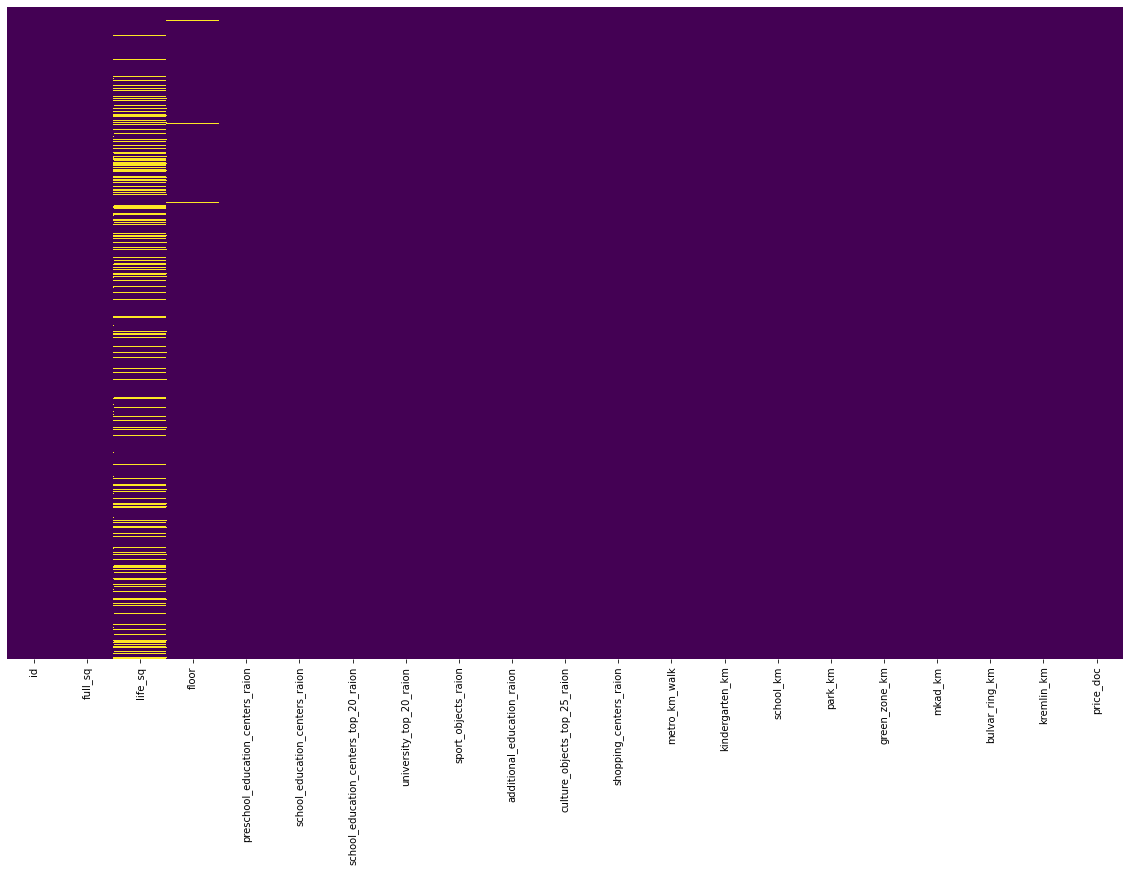

In [5]:
# Визуально пропуски будут выглядеть следующим образом:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Фиолетовым цветом показаны заполненные ячейки, а жёлтым - пропущенные значения. В основном пропуски сосредоточены в одном признаке - жилой площади. Столбец life_sq не будет приниматься во внимание, будет удалён.

In [6]:
# Удаление столбца life_sq
del data['life_sq']

<AxesSubplot:>

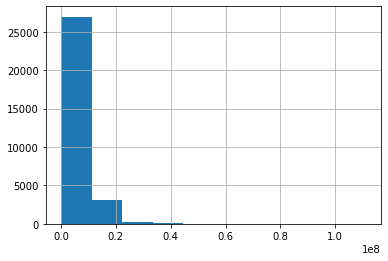

In [7]:
# Визуализируем распределение целевой переменной, чтобы понять, какие значения мы будем предсказывать:
data.price_doc.hist()

Распределение цен показывает, что присутствует сильный перепад. Много квартир в среднем сегменте цен, и мало дорогих квартир. Чтобы уменьшить перепады и сгладить "хвост" прологарифмирует значения целевого признака price_doc

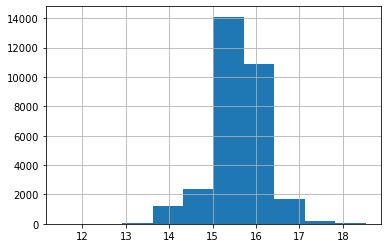

In [8]:
# Логарифмируем
data['price_doc'] = data['price_doc'].apply(lambda w: np.log(w + 1))
# Визуализируем
data.price_doc.hist();

Проведём отбор признаков. Проверим, нет ли мультиколлинеарности — сильной взаимосвязи между независимыми признаками. Для этого построим матрицу корреляций для признаков:

<AxesSubplot:>

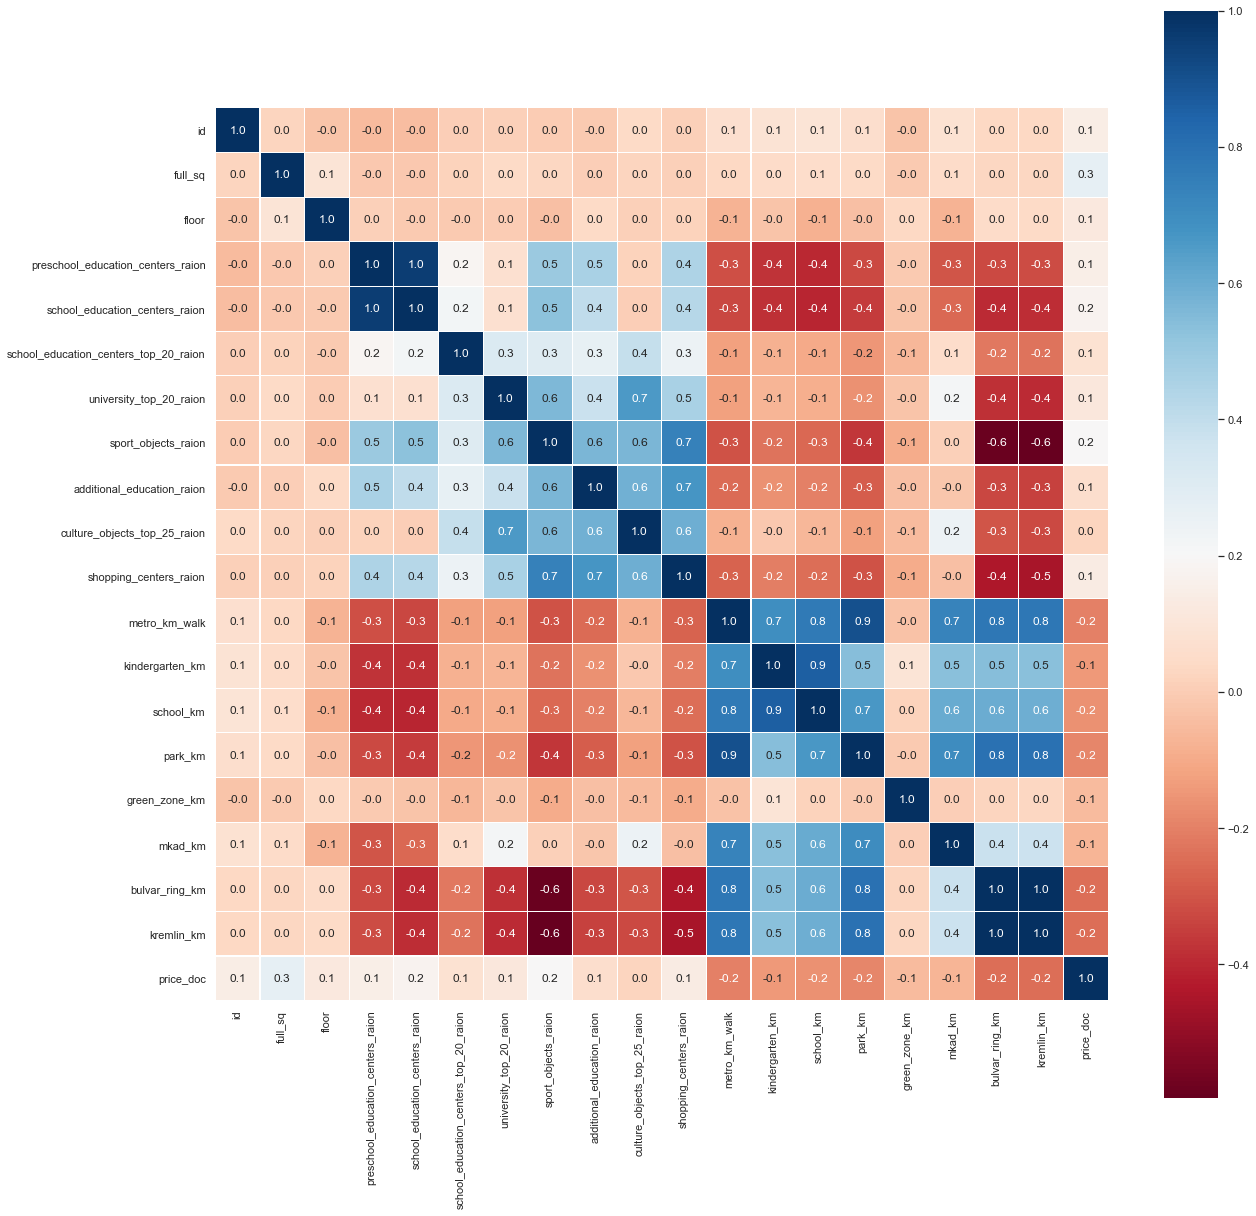

In [9]:
sns.set(font_scale=1)
plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

1. <b>Количество школ и количество детских садов.</b> Довольно логично, так как в Москве детские сады обычно присоединены к школам. Оставляем школы, т.к. у этого признака больше взаимосвязь с целевой переменной. Удаляем столбец preschool_education_centers_raion
2. <b>Расстояние до школ и расстояние до детских садов.</b> По сути, это естественным образом вытекает из предыдущего пункта. Оставляем расстояние до школ. Удаляем столбец kindergarten_km
3. <b>Расстояние до парка и до метро.</b> Рассуждая аналогично предыдущим парам, оставляем расстояние до метро. Удаляем столбец green_zone_km
4. <b>Расстояние до Кремля и до бульварного кольца.</b> У них коэффициент корреляции равен 1, и их корреляция с целевой переменной одинаковая. Поэтому можем убрать любой признак. Убираем расстояние до Кремля kremlin_km.
5. Удаляем столбец id, вследствии его неинформативности

In [10]:
# Удаляем выше определённые столбцы
data = data.drop(['kremlin_km','preschool_education_centers_raion', 'kindergarten_km',
    'park_km', 'id'], axis=1, inplace=False)

In [11]:
# Удаляем строки в которых встречается хотябы один пропуск
data = data.dropna()
# Выводим информацию предобработанного датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30277 entries, 0 to 30468
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   full_sq                                30277 non-null  int64  
 1   floor                                  30277 non-null  float64
 2   school_education_centers_raion         30277 non-null  int64  
 3   school_education_centers_top_20_raion  30277 non-null  int64  
 4   university_top_20_raion                30277 non-null  int64  
 5   sport_objects_raion                    30277 non-null  int64  
 6   additional_education_raion             30277 non-null  int64  
 7   culture_objects_top_25_raion           30277 non-null  int64  
 8   shopping_centers_raion                 30277 non-null  int64  
 9   metro_km_walk                          30277 non-null  float64
 10  school_km                              30277 non-null  float64
 11  gr

In [12]:
# Разделяем датасет на две составляющие:
# 1. у - вектор целевой переменной
# 2. X - матрица независимых переменных по которым будет обучаться модель.
y = list(data['price_doc'])
X = data.drop(['price_doc'], axis=1)

In [13]:
# Для формирования выборки импортируем необходимый модуль
from sklearn.model_selection import train_test_split

# Фиксируем тестовую выборку размером test_size=0.2, random_state=77
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

Нормализуем признаки датасета. Нормализация данных позволяет всем признакам вносить одинаковый вклад (или, что более точно, позволяет добавлять признаки в зависимости от их важности, а не их масштаба).

In [14]:
# Для нормализации отбранных признаков импортируем модуль нормализации
from sklearn.preprocessing import robust_scale

# Нормализация признаков
X_train_trans = robust_scale(X_train, axis=0)
X_test_trans = robust_scale(X_test, axis=0)

### РАСЧЁТ параметров линейного уравнения A и B y = A*x+B

Вычисляем
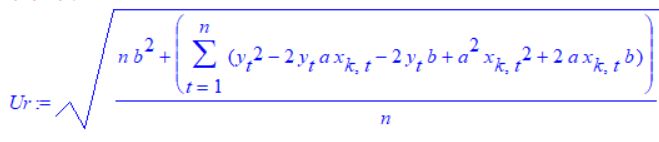
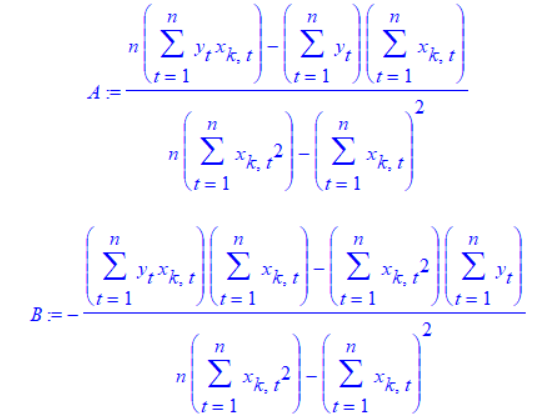

#### Где:

yt = y_train[t]

xk,t = X_train_trans[k,t]   k - номер столбца,   t - индекс строки от 0 до len(X[k])

## Общий модуль вычисления B и A

In [15]:
Y = y_train.copy()
X = X_train_trans.copy()
B = []
A = []
Sy = sum(Y)
n = len(X)
for k in range(0,len(X[0])):
    Sxy =sum([Y[t]*X[t][k] for t in range(0,len(X))])
    Sx2 = sum([X[t][k]**2 for t in range(0,len(X))])
    Sx = sum([X[t][k] for t in range(0,len(X))])
    c = (Sx2*Sy -Sx*Sxy)/(n*Sx2-Sx**2)
    a = (n*Sxy-Sy*Sx)/(n*Sx2-Sx**2)
    A.append(a)
    B.append(c)

### Вывод вычисленных коэффициентов системы для данного датасет

In [16]:
Aa = [x/len(A) for x in A]
print(Aa)
Bb = sum(B)/len(B)
print(Bb)

[0.006641494858029129, 0.007844781238558836, 0.010762397945031713, 0.010028171654276108, 0.010696420391388486, 0.011613437908698348, 0.0023769945364793196, 0.0006819187358092513, 0.006293424648300199, -0.004273887278001431, -0.001363384068533143, -0.002372277737839902, -0.002980508386798935, -0.01305237462201885]
15.608445777714312


### Оценка результатов вычисления на тестовой выборке

In [17]:
zz = 0
pr =[]
X = X_test_trans.copy()
Y = y_test.copy()
for k in  range(0,len(X)):
    y = sum([X[k][t]*Aa[t] for t in range(0,len(X[0]))]) + Bb
    pr.append(y*100/Y[k])
    z = (Y[k] - y)**2
    zz+=z
print((zz/len(X))**(1/2)) # Среднеквадратичное отклонение прдсказывания
print(round(sum(pr)/len(pr),2),'%') # Средняя точность в процентах предсказывания


0.5871776473202487
100.13 %
